# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Machine-learning-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Dataset Parameters

In [1]:
num_images = 20000 # Number of images to create for the dataset
num_bees = 10 # Maximum number of bees to include per image
EX_SUB = 1
VAL_SIZE = 0.1
FILL_IMG = 0 # need to change; inpaint only works with 3-channel images

print("Done")

Done


## Library Imports

In [2]:
from datetime import datetime
import tensorflow_datasets as tfds
import json
import os
import glob
import random
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from GEORGE_Library import *
import sys
sys.path.append("BestBGRemove")
from BestBGRemove import *
sys.path.append("Detection_to_XML")
from Detection_to_XML import CreateXMLfile, xml_to_csv
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print("Done")

C:\Users\khard\.conda\envs\tf\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Done


## Feeder Image Array Creation

In [3]:
train_augmented_fp = "Dataset/Custom_Dataset/"
#val_augmented_fp = "Dataset/ValAugmented"
pi_fp = 'Pi_Images'

try:
    files = os.listdir(train_augmented_fp)
    for file in files:
        file_path = os.path.join(train_augmented_fp, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
    # files = os.listdir(val_augmented_fp)
    # for file in files:
    #     file_path = os.path.join(val_augmented_fp, file)
    #     if os.path.isfile(file_path):
    #         os.remove(file_path)
except OSError:
    print("Error")

dataset_paths = {
                 'PD': {'none': {'path': 'Dataset/PollenDataset/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/PollenDataset/Pollen', 'label': [1, 0, 0]}},
                 'BA': {'none': {'path': 'Dataset/BeeAlarmed/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/BeeAlarmed/Pollen', 'label': [1, 0, 0]},
                        'varroa': {'path': 'Dataset/BeeAlarmed/Varroa', 'label': [0, 1, 0]},
                        'wasps': {'path': 'Dataset/BeeAlarmed/Wasps', 'label': [0, 0, 1]}},
                 # 'YM': {'none': {'path': 'Dataset/YangModel/None', 'label': [0, 0, 0]},
                 #        'pollen': {'path': 'Dataset/YangModel/Pollen', 'label': [1, 0, 0]},
                 #        'varroa': {'path': 'Dataset/YangModel/Varroa', 'label': [0, 1, 0]}},
                 # 'USU': {'none': {'path': 'Dataset/USU/None', 'label': [0, 0, 0]},
                 #         'pollen': {'path': 'Dataset/USU/Pollen', 'label': [1, 0, 0]},
                 #         'varroa': {'path': 'Dataset/USU/Varroa', 'label': [0, 1, 0]}},
                }

file_list = []
for dataset_path in dataset_paths:
    for dataset in dataset_paths[dataset_path]:
        [file_list.append(i) for i in glob.glob(dataset_paths[dataset_path][dataset]['path'] + '/*')]

pi_list = []
[pi_list.append(i) for i in glob.glob(pi_fp + '/*')]

print("Done")

Done


## Dataset Creation Loop

In [4]:
# NOTE: COCO Dataset IDs start with 1

images = []
annotations = []
licenses = []

categories = [category(1, "None", None), category(2, "Pollen", None), category(3, "Varroa", None), category(4, "Wasps", None)]

# License creation "loop"
License_Id = 1
Name = 'Attribution-NonCommercial-ShareAlike 4.0 International'
Url = 'https://creativecommons.org/licenses/by-nc-sa/4.0/'
licenses.append(license(License_Id, Name, Url))

img_width = 640
img_height = 640
License = 1
Flickr_url = None
Coco_url = None
Annotation_Id = 1

with tqdm(total = num_images, unit="image") as pbar:
    for image_id in range(num_images):
        BG_img = Image.open(random.choice(pi_list)).convert('RGB')
        BG_width, BG_height = BG_img.size
        i = random.randint(0,2)
        left = 640 * i
        bottom =  int(BG_height - ((BG_height - 640) / 2))
        right = 640 * (i + 1)
        top = int((BG_height - 640) / 2)
        BG_img = BG_img.crop((left, top, right, bottom))
        
        Id = image_id + 1
        File_name = Id
        Date_captured = str(datetime.now())
        
        # Feeder image usage sub-loop (annotation sub-loop)
        for bee in range(random.randint(1, num_bees)): # number of bees to include in image
            Image_id = Id
    
            current_bee = os.path.normpath(random.choice(file_list)) # Grab a random bee from feeder images
            category_name = os.path.dirname(current_bee).split('\\')[-1] # Get category of feeder image from containing directory
            Category_id = [i.id for i in categories if i.name == category_name][0]
    
            image = Image.open(current_bee).convert('RGB')
            new_image = image
    
            if max(image.size) < min(IMAGE_WIDTH, IMAGE_HEIGHT): # Resize feeder image if required
                ind = np.argmax(image.size)
                size = np.zeros(2)
                size[ind] = min(IMAGE_WIDTH, IMAGE_HEIGHT)
                size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
                new_image = image.resize((round(size[0]), round(size[1])))
            elif min(image.size) > max(IMAGE_WIDTH, IMAGE_HEIGHT):
                ind = np.argmin(image.size)
                size = np.zeros(2)
                size[ind] = max(IMAGE_WIDTH, IMAGE_HEIGHT)
                size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
                new_image = image.resize((round(size[0]), round(size[1])))
            if np.array(new_image).max() <= 1: # Normalize feeder image if required
                new_image = np.array(new_image) * 255
            new_image = automatic_brightness_and_contrast(np.array(new_image).astype('uint8'))
            new_image = zoom_image(new_image)
            if EX_SUB:
                if current_bee.split("\\")[1] == "PollenDataset":
                    starting_params = [159, 217, 81, [], 84, 191, 1, 9, 5.706, 3]
                    new_image, _ = do_image(np.array(new_image), *starting_params)
                    new_image = brightness_match(BG_img, new_image)
                    #Image.fromarray(img1).save(tmp_fp + current_bee.split("\\")[0] + "\\" + current_bee.split("\\")[-1].split(".")[0] + ".png")
                elif current_bee.split("\\")[1] == "BeeAlarmed":
                    starting_params = [71, 203, 177, [], 134, 209, 1, 9, 3.204, 9]
                    new_image, _ = do_image(np.array(new_image), *starting_params)
                    new_image = brightness_match(BG_img, new_image)
                    #Image.fromarray(img1).save(tmp_fp + current_bee.split("\\")[0] + "\\" + current_bee.split("\\")[-1].split(".")[0] + ".png")
                elif current_bee.split("\\")[1] == "YangModel":
                    pass
            BG_img, new_coords = process_image(np.array(new_image).astype('uint8'), BG_img)
            new_coords = new_coords * 640
            str_name = []
            for coord in new_coords:
                str_name.append(str(coord).split('.')[1])
    
            Segmentation = None
            X = new_coords[1]
            Y = new_coords[0]
            Width = new_coords[3] - X
            Height = new_coords[2] - Y
            Area = Width * Height
            Bbox = bbox(X, Y, Width, Height)
            Iscrowd = 0 # Pretty sure this is perpetually zero for this dataset
            
            annotations.append(annotation(Annotation_Id, Image_id, Category_id, Segmentation, Area, Bbox, Iscrowd))
            Annotation_Id = Annotation_Id + 1
        Image.fromarray(np.array(BG_img).astype('uint8')).save(train_augmented_fp + str(File_name) + ".png","PNG")
        images.append(img(Id, img_width, img_height, File_name, License, Flickr_url, Coco_url, Date_captured))
        pbar.update(1)

info = {
        "year": 2024,
        "version": 1.0,
        "description": "GEORGE Custom Dataset",
        "contributor": "Kevin Hardin",
        "url": "https://www.kaggle.com/datasets/kevinhardin/george-augmented-dataset",
        "date_created": str(datetime.now()),
        }

with open("custom_bee_dataset.json", "w") as outfile:
    json.dump({"info": info, "images": [json.loads(i.toJSON()) for i in images], "annotations": [json.loads(i.toJSON()) for i in annotations], "licenses": [json.loads(i.toJSON()) for i in licenses], "categories": [json.loads(i.toJSON()) for i in categories]}, outfile, indent = 4)

print("Done")

100%|███████████████████████████████████████████████████████████████████████| 20000/20000 [2:28:08<00:00,  2.25image/s]


Done


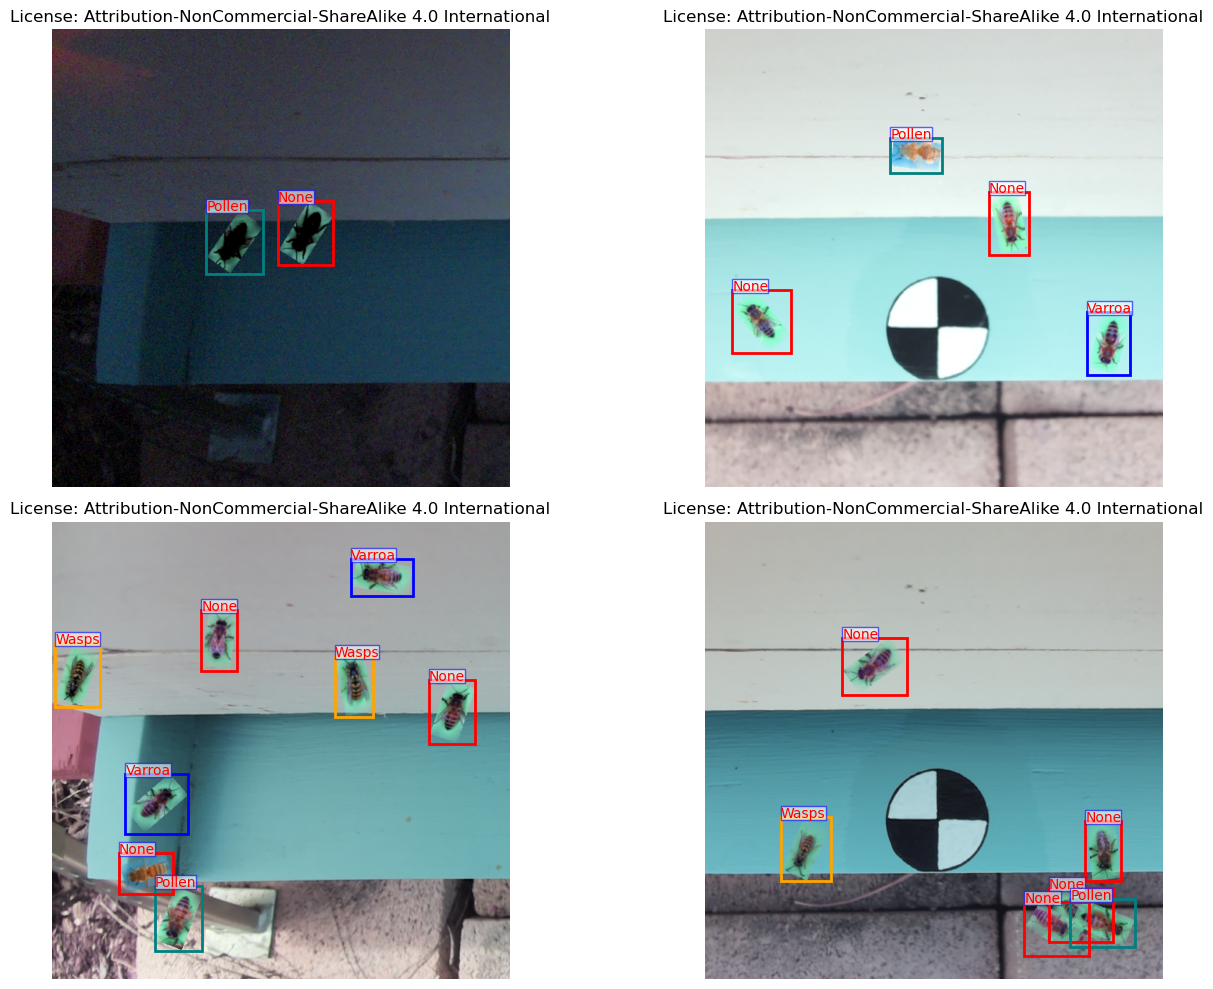

In [25]:
coco_annotations_file="custom_bee_dataset.json"
coco_images_dir=os.getcwd() + "\\" + train_augmented_fp
coco= COCOParser(coco_annotations_file, coco_images_dir)

# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = coco.get_annIds(selected_img_ids)
im_licenses = coco.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/{str(im).zfill(0)}.png")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        _bbox = ann['bbox']
        x, y, w, h = [int(b) for b in _bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        _license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)
    
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {_license}")
plt.tight_layout()
plt.show()